## Setup

In [1]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

# uncomment when acttually working on this, it's here for reproducibility though
fix_all_rngs(42) 

Using TensorFlow backend.


## Load data

> BTC-USD: 1324 data points
  from 2015-02-28 00:00:00 to 2018-10-13 00:00:00


close   open   high    low  volume  missing
datetime                                               
2015-02-28  253.0  253.1  254.3  245.2    3.61        0

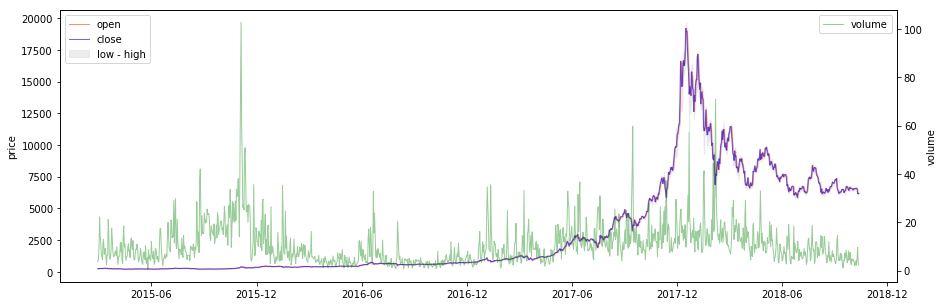



---------
> stock OSTK: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume   open   high    low  missing  weekday  \
datetime                                                              
2018-10-11  24.86  1809443.0  25.15  25.89  24.14      0.0        3   
2018-10-12  26.40  1250256.0  25.38  26.44  24.77      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

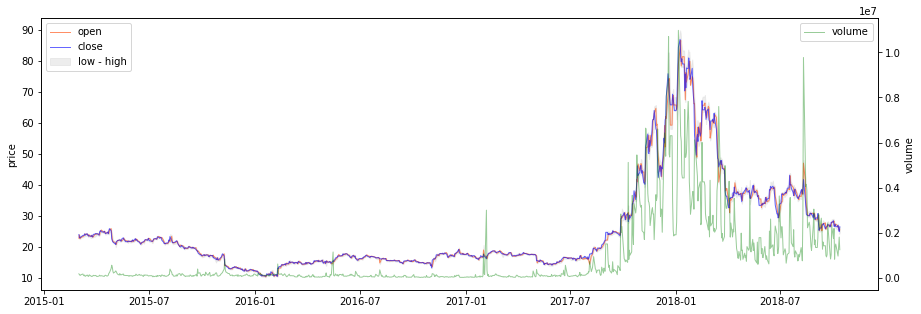



---------
> stock RIOT: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume  open    high   low  missing  weekday  close_btc  \
datetime                                                                        
2018-10-11   2.16   662046.0  2.15  2.3204  2.15      0.0        3     6161.0   
2018-10-12   2.57  4981702.0  2.22  3.1100  2.22      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

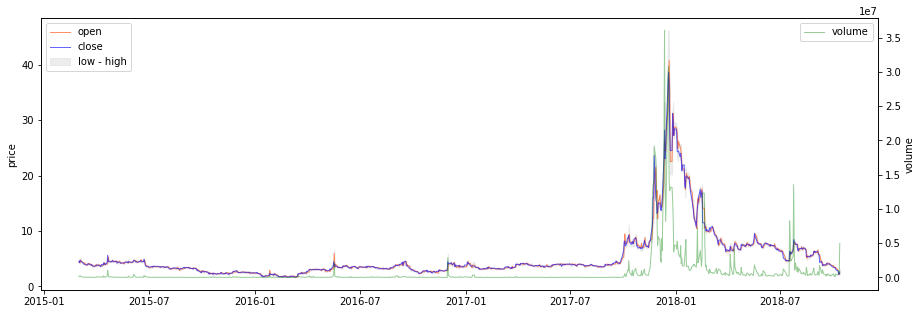



---------
> stock AMD: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close       volume   open     high    low  missing  weekday  \
datetime                                                                  
2018-10-11  25.30  146516800.0  24.74  26.2000  24.55      0.0        3   
2018-10-12  26.34  110862700.0  26.77  26.9697  25.67      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

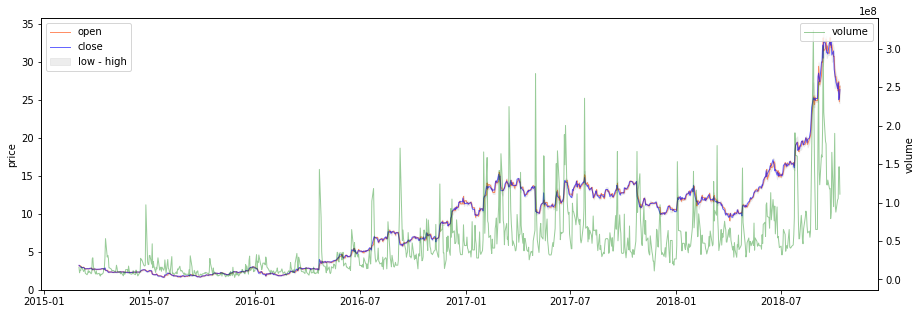



---------
> stock OTIV: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume  open  high    low  missing  weekday  close_btc  \
datetime                                                                      
2018-10-11  0.9112  74004.0  0.94  0.94  0.855      0.0        3     6161.0   
2018-10-12  0.9400  64730.0  0.91  0.94  0.886      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

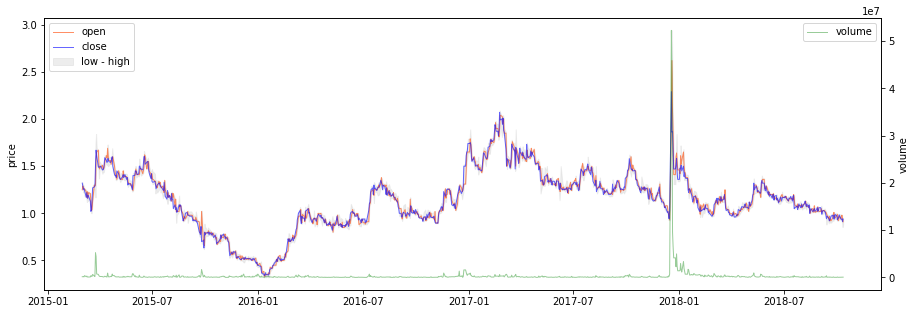



---------
> stock NVDA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close      volume      open      high      low  missing  weekday  \
datetime                                                                        
2018-10-11  235.13  18063810.0  242.1700  247.5600  234.261      0.0        3   
2018-10-12  246.54  15121060.0  245.5066  249.5412  239.650      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

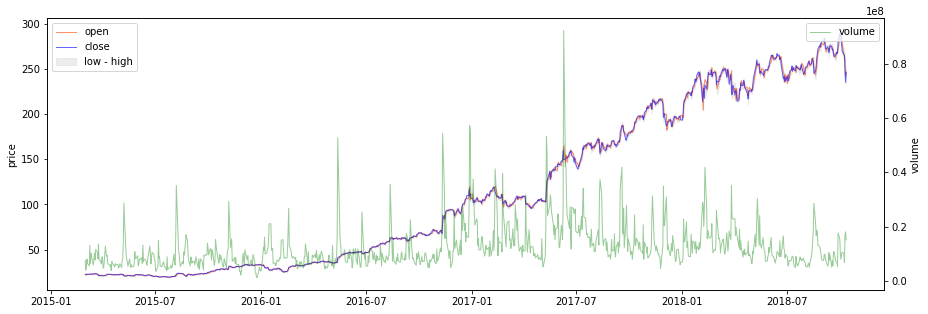



---------
> stock SIEB: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume   open   high    low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11  12.96  10389.0  13.00  13.46  12.95      0.0        3     6161.0   
2018-10-12  13.09  10455.0  13.27  13.87  13.02      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

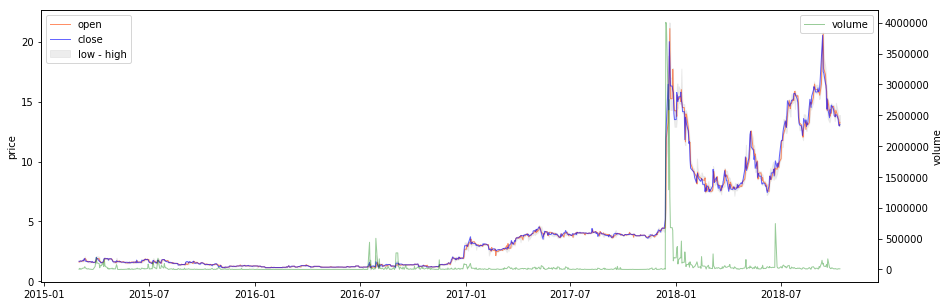



---------
> stock GBTC: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume   open  high   low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11   6.78  2474177.0  6.990  6.99  6.75      0.0        3     6161.0   
2018-10-12   6.85  1168809.0  6.865  6.99  6.78      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

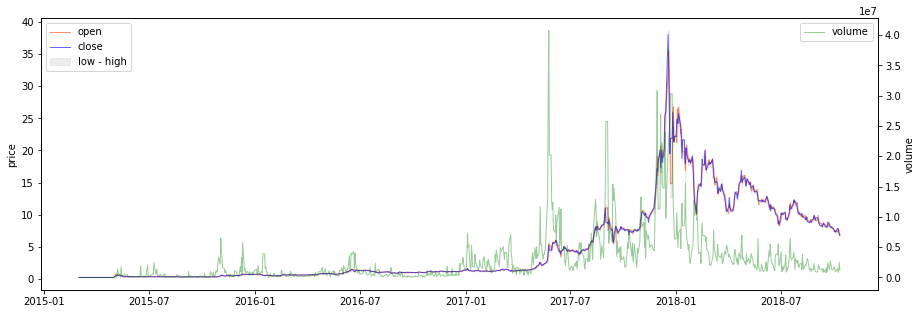



---------
> stock MARA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open   high   low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11  0.5850  734764.0  0.63  0.630  0.57      0.0        3     6161.0   
2018-10-12  0.6085  698911.0  0.60  0.678  0.59      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

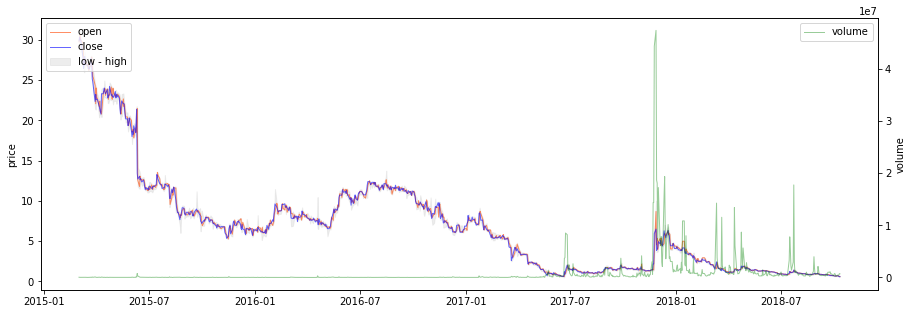

In [5]:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}

data_btc = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
data_btc = data_btc[data_btc.index >= '2015-02-28']
print("> BTC-USD: %d data points" % (len(data_btc),))
print("  from %s to %s" % (data_btc.iloc[0].name, data_btc.iloc[-1].name))
simple_plot(data_btc, show_xlabels=False)
dd(data_btc.head(1))
plt.show()

stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    data = etl.augment(data, data_btc, 7, '_btc')
    stocks_data[stock] = data
    print("\n\n---------")
    print("> stock %s: %d data points" % (stock.upper(), len(data)))
    print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
    dd(data.tail(2))
    simple_plot(data, show_xlabels=False)
    plt.show()

## Full runs

In [6]:
DEFAULT_PARAMS = {
    # data to extract:
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor(
        [7, 0.1, 7, 0.1],
        optimizer=keras.optimizers.RMSprop,
        lr=1e-4,
    ),
    # training:
    'epochs': 100,
    'batch_size': 32,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [7]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [12]:
def full_run(
    idx_from, idx_to, data, out_filename,
    write_csv_header, params,
    method=run_walk_forward_validation_rnn,
):
    train_sz = params['train_sz']
    test_sz = params['test_sz']
    
#     out_file = open(out_filename, 'ab')
    out_file = open(out_filename, 'wb')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(params,
                          from_i=i - train_sz,
                          data_df=data)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                del out['train_val_losses']
                csv_writer.writerow(out)
                out_file.flush()

## OHLCW predictions



        #################################
        # ostk
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.022s to model compilation time


--- Created model id: 140512445865360
Tensor("lstm_17_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_18 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)        

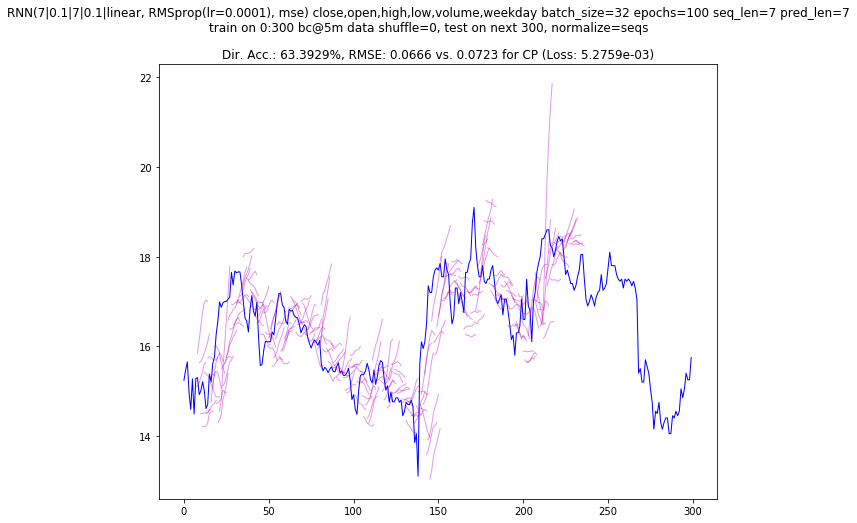

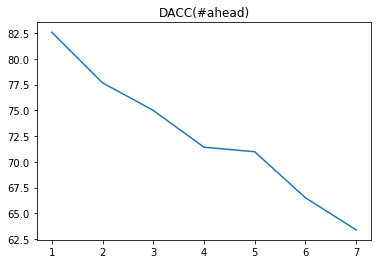

--- 12.034s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140512434058896
Tensor("lstm_19_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_20 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 209us/step - loss: 0.0066 - val_loss: 0.0043
Epoch 68/100
262/262 [==============================] - 0s 222us/step - loss: 0.0063 - val_loss: 0.0043
Epoch 69/100
262/262 [==============================] - 0s 210us/step - loss: 0.0055 - val_loss: 0.0043
Epoch 70/100
262/262 [==============================] - 0s 218us/step - loss: 0.0064 - val_loss: 0.0043
Epoch 71/100
262/262 [==============================] - 0s 204us/step - loss: 0.0059 - val_loss: 0.0042
Epoch 72/100
262/262 [==============================] - 0s 236us/step - loss: 0.0061 - val_loss: 0.0042
Epoch 73/100
262/262 [==============================] - 0s 210us/step - loss: 0.0054 - val_loss: 0.0042
Epoch 74/100
262/262 [==============================] - 0s 210us/step - loss: 0.0052 - val_loss: 0.0042
Epoch 75/100
262/262 [==============================] - 0s 227us/step - loss: 0.0057 - val_loss: 0.0042
Epoch 76/100
262/262 [==============================] - 0s 206us/step - loss:

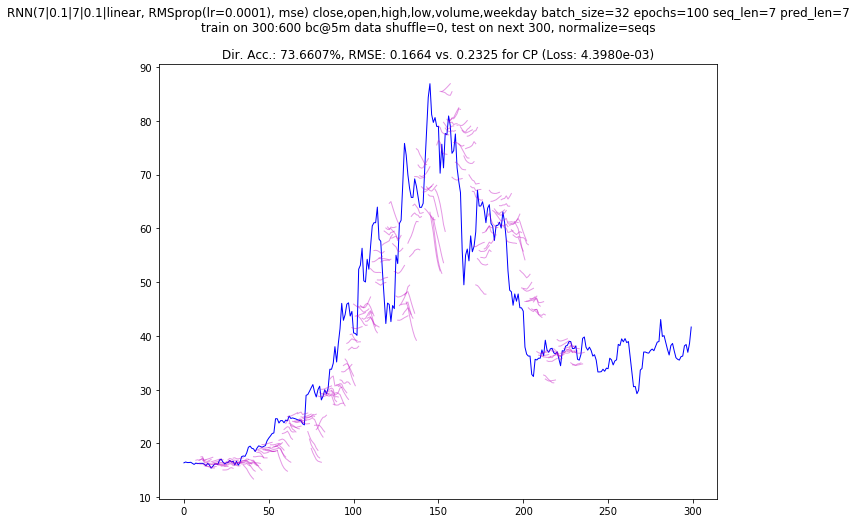

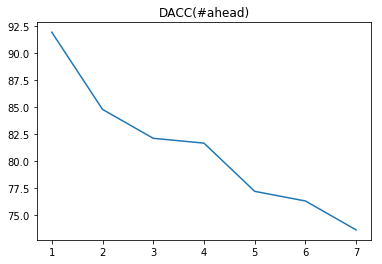

--- 11.440s to run segment

--- 23.474s to full run 300 - 638



        #################################
        # riot
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140512404895056
Tensor("lstm_21_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_22 (Dropout)         (None, 7)                 0         
__________________________

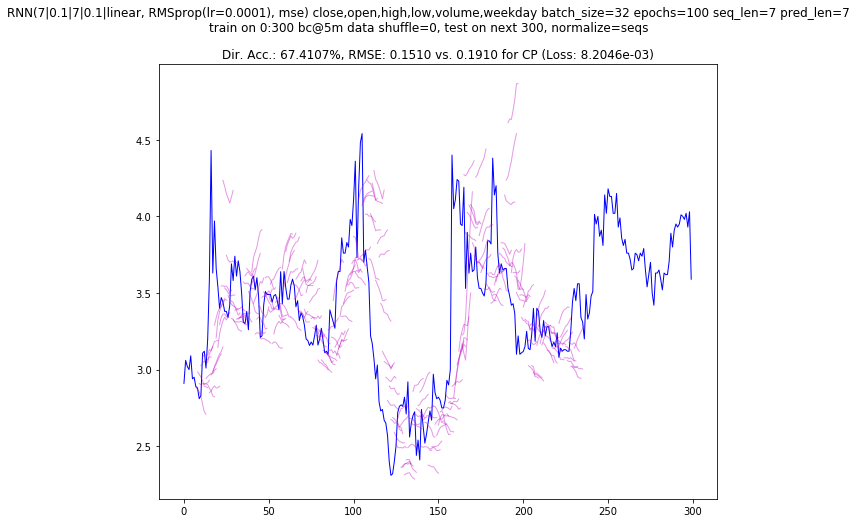

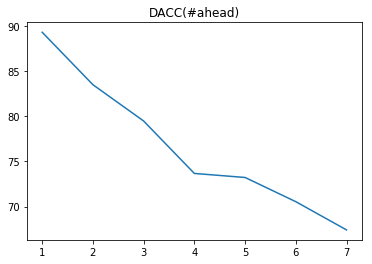

--- 12.313s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 140512389926288
Tensor("lstm_23_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_24 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 229us/step - loss: 0.0151 - val_loss: 0.0024
Epoch 68/100
262/262 [==============================] - 0s 232us/step - loss: 0.0137 - val_loss: 0.0025
Epoch 69/100
262/262 [==============================] - 0s 236us/step - loss: 0.0141 - val_loss: 0.0025
Epoch 70/100
262/262 [==============================] - 0s 245us/step - loss: 0.0150 - val_loss: 0.0025
Epoch 71/100
262/262 [==============================] - 0s 253us/step - loss: 0.0147 - val_loss: 0.0025
Epoch 72/100
262/262 [==============================] - 0s 259us/step - loss: 0.0155 - val_loss: 0.0025
Epoch 73/100
262/262 [==============================] - 0s 245us/step - loss: 0.0139 - val_loss: 0.0025
Epoch 74/100
262/262 [==============================] - 0s 242us/step - loss: 0.0139 - val_loss: 0.0025
Epoch 75/100
262/262 [==============================] - 0s 241us/step - loss: 0.0153 - val_loss: 0.0025
Epoch 76/100
262/262 [==============================] - 0s 246us/step - loss:

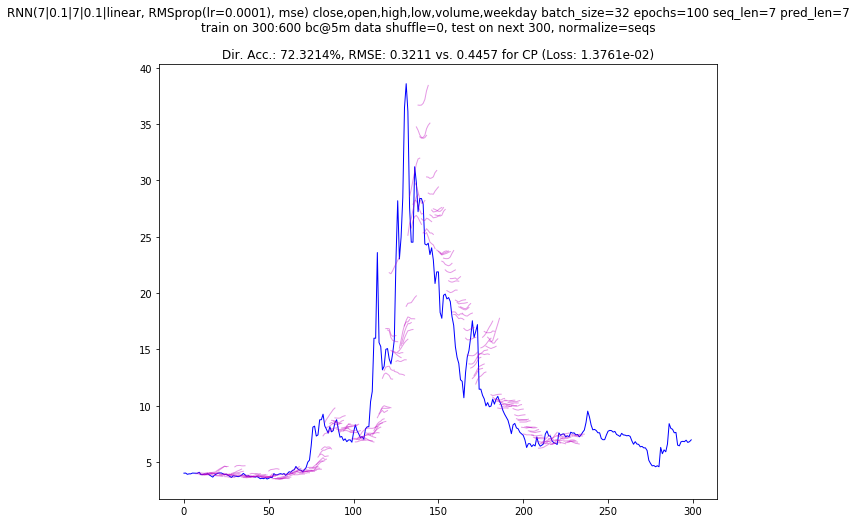

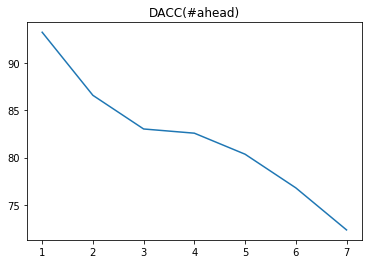

--- 12.874s to run segment

--- 25.187s to full run 300 - 638



        #################################
        # amd
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 140512369397264
Tensor("lstm_25_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
___________________________

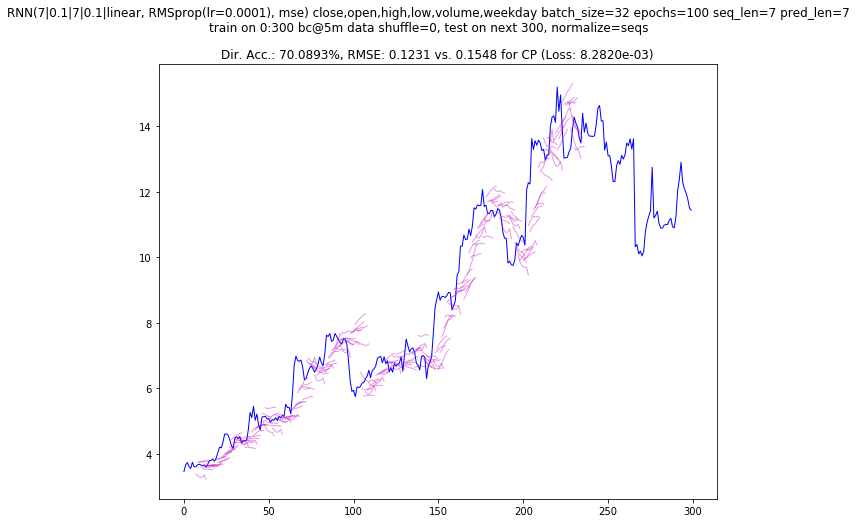

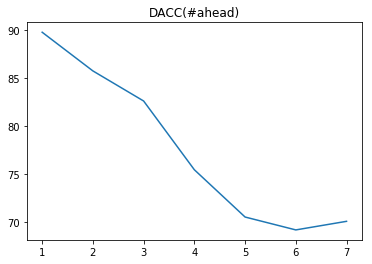

--- 13.707s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140512372094416
Tensor("lstm_27_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_28 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

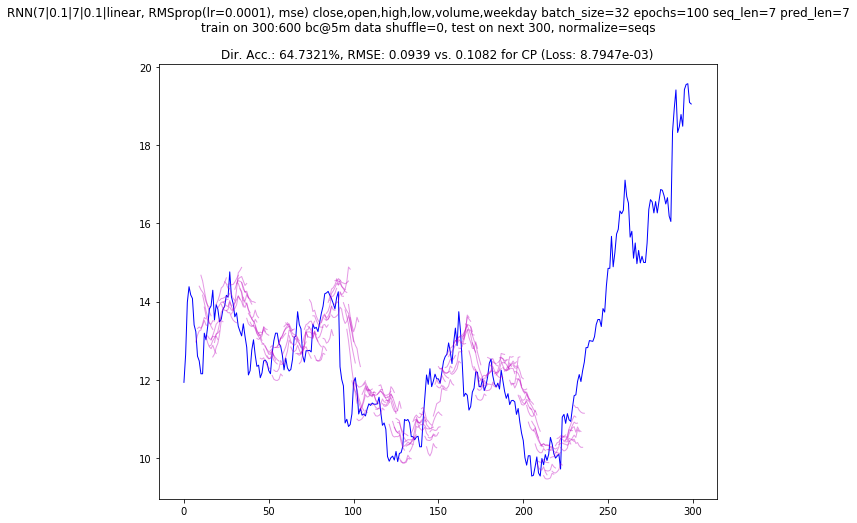

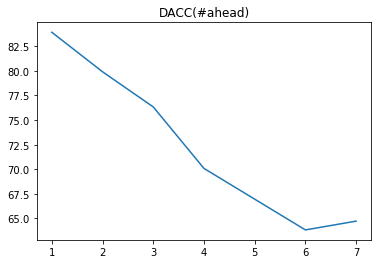

--- 83.424s to run segment

--- 97.132s to full run 300 - 638



        #################################
        # otiv
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.179s to model compilation time


--- Created model id: 140512331842064
Tensor("lstm_29_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_29 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_30 (Dropout)         (None, 7)                 0         
__________________________

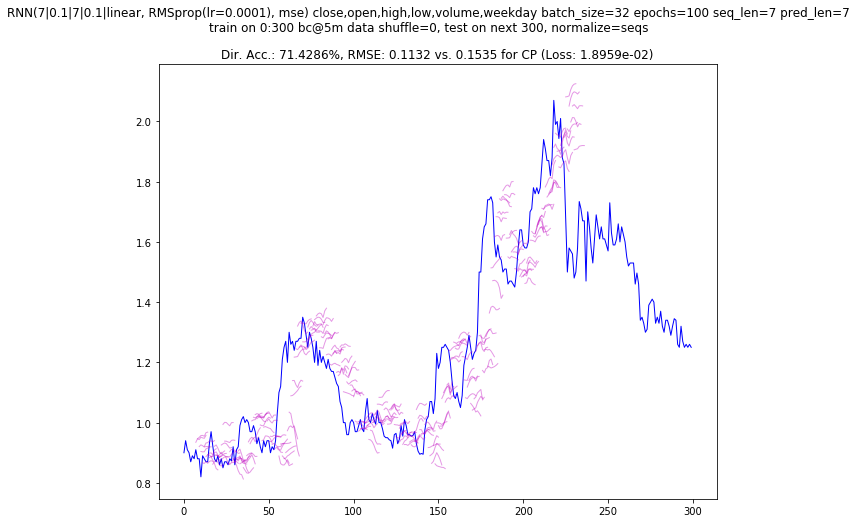

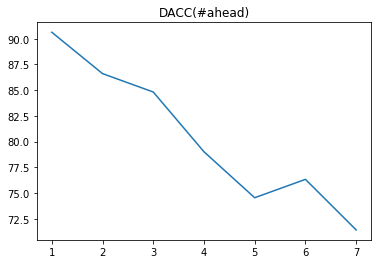

--- 44.893s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.018s to model compilation time


--- Created model id: 140512311499792
Tensor("lstm_31_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_32 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 282us/step - loss: 0.0188 - val_loss: 0.0042
Epoch 68/100
262/262 [==============================] - 0s 279us/step - loss: 0.0185 - val_loss: 0.0042
Epoch 69/100
262/262 [==============================] - 0s 256us/step - loss: 0.0186 - val_loss: 0.0041
Epoch 70/100
262/262 [==============================] - 0s 272us/step - loss: 0.0184 - val_loss: 0.0040
Epoch 71/100
262/262 [==============================] - 0s 265us/step - loss: 0.0177 - val_loss: 0.0039
Epoch 72/100
262/262 [==============================] - 0s 255us/step - loss: 0.0176 - val_loss: 0.0039
Epoch 73/100
262/262 [==============================] - 0s 267us/step - loss: 0.0177 - val_loss: 0.0038
Epoch 74/100
262/262 [==============================] - 0s 254us/step - loss: 0.0160 - val_loss: 0.0037
Epoch 75/100
262/262 [==============================] - 0s 229us/step - loss: 0.0160 - val_loss: 0.0036
Epoch 76/100
262/262 [==============================] - 0s 246us/step - loss:

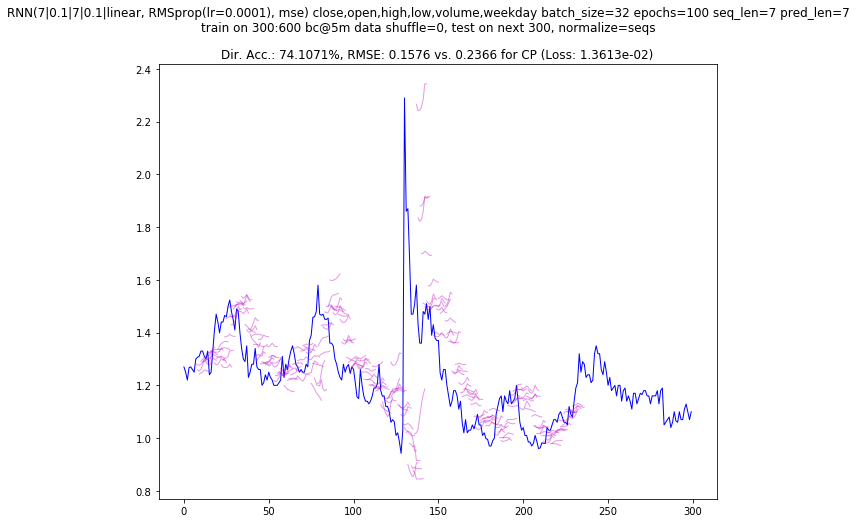

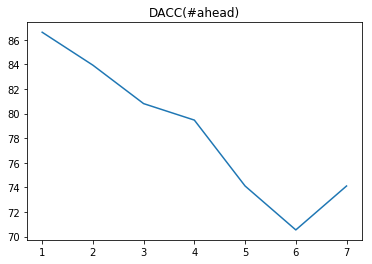

--- 15.018s to run segment

--- 59.912s to full run 300 - 638



        #################################
        # nvda
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140512311908368
Tensor("lstm_33_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
__________________________

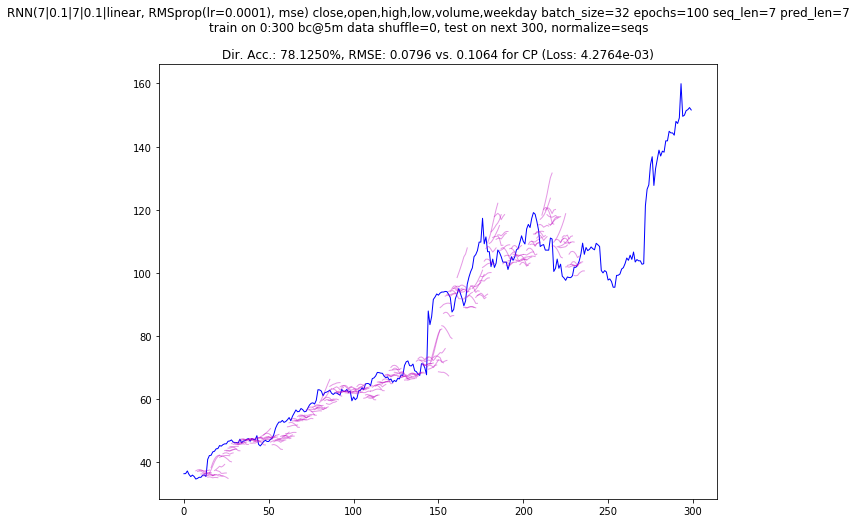

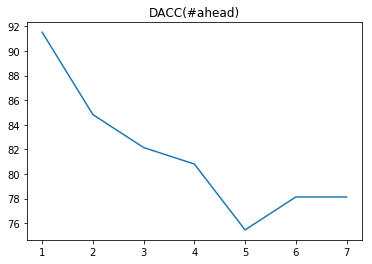

--- 14.148s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.018s to model compilation time


--- Created model id: 140512279997008
Tensor("lstm_35_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_36 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 301us/step - loss: 0.0091 - val_loss: 0.0221
Epoch 68/100
262/262 [==============================] - 0s 276us/step - loss: 0.0093 - val_loss: 0.0218
Epoch 69/100
262/262 [==============================] - 0s 263us/step - loss: 0.0086 - val_loss: 0.0215
Epoch 70/100
262/262 [==============================] - 0s 265us/step - loss: 0.0087 - val_loss: 0.0211
Epoch 71/100
262/262 [==============================] - 0s 276us/step - loss: 0.0089 - val_loss: 0.0207
Epoch 72/100
262/262 [==============================] - 0s 268us/step - loss: 0.0086 - val_loss: 0.0204
Epoch 73/100
262/262 [==============================] - 0s 285us/step - loss: 0.0080 - val_loss: 0.0201
Epoch 74/100
262/262 [==============================] - 0s 293us/step - loss: 0.0081 - val_loss: 0.0197
Epoch 75/100
262/262 [==============================] - 0s 273us/step - loss: 0.0085 - val_loss: 0.0194
Epoch 76/100
262/262 [==============================] - 0s 277us/step - loss:

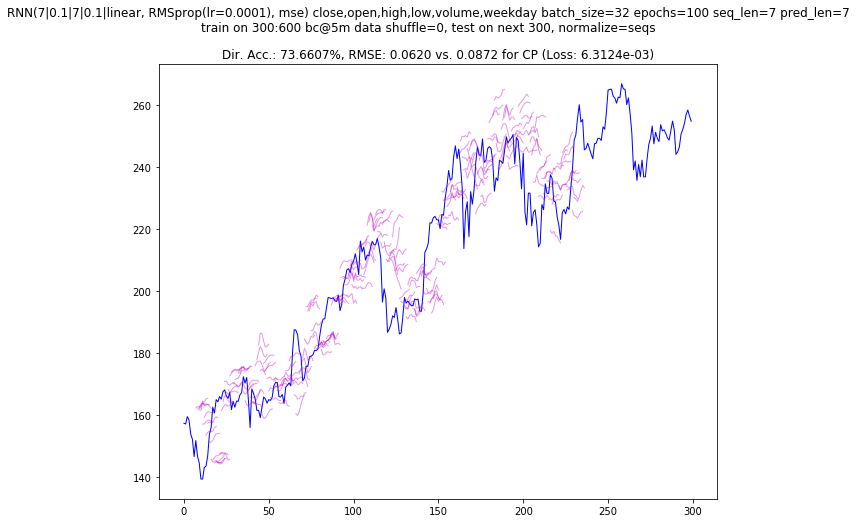

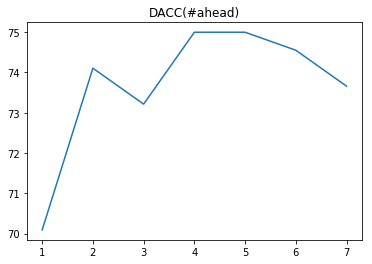

--- 15.606s to run segment

--- 29.754s to full run 300 - 638



        #################################
        # sieb
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140512257932624
Tensor("lstm_37_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_37 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_38 (Dropout)         (None, 7)                 0         
__________________________

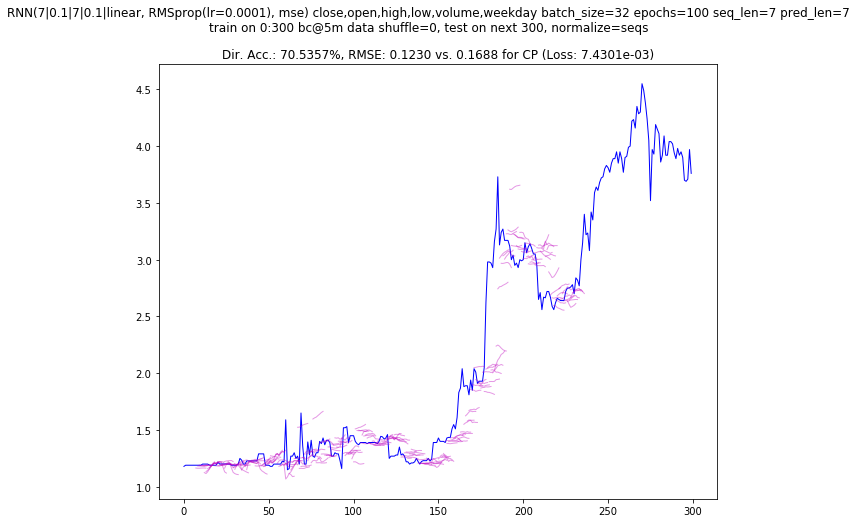

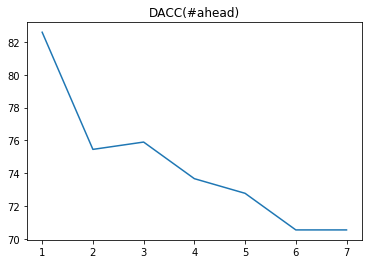

--- 14.538s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140512257243792
Tensor("lstm_39_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_39 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_40 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 445us/step - loss: 0.0158 - val_loss: 0.0094
Epoch 68/100
262/262 [==============================] - 0s 434us/step - loss: 0.0162 - val_loss: 0.0094
Epoch 69/100
262/262 [==============================] - 0s 400us/step - loss: 0.0154 - val_loss: 0.0094
Epoch 70/100
262/262 [==============================] - 0s 384us/step - loss: 0.0157 - val_loss: 0.0093
Epoch 71/100
262/262 [==============================] - 0s 460us/step - loss: 0.0161 - val_loss: 0.0094
Epoch 72/100
262/262 [==============================] - 0s 588us/step - loss: 0.0158 - val_loss: 0.0094
Epoch 73/100
262/262 [==============================] - 0s 681us/step - loss: 0.0145 - val_loss: 0.0094
Epoch 74/100
262/262 [==============================] - 0s 507us/step - loss: 0.0161 - val_loss: 0.0094
Epoch 75/100
262/262 [==============================] - 0s 402us/step - loss: 0.0165 - val_loss: 0.0093
Epoch 76/100
262/262 [==============================] - 0s 414us/step - loss:

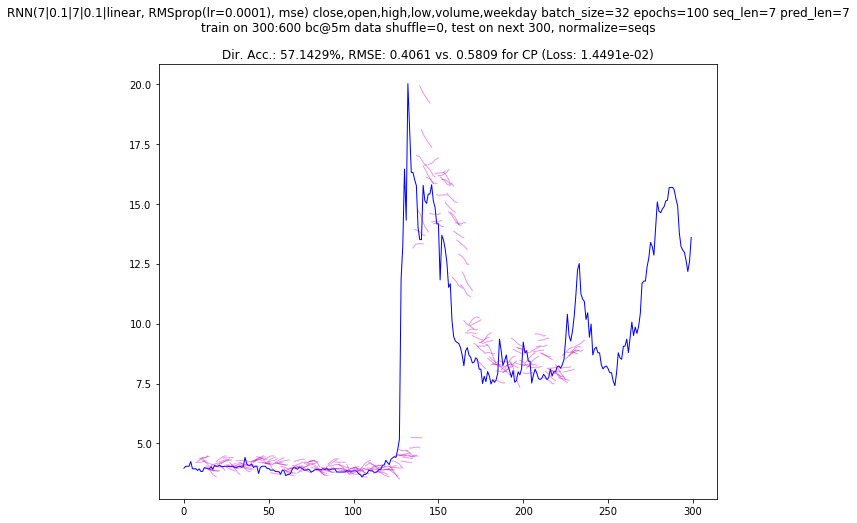

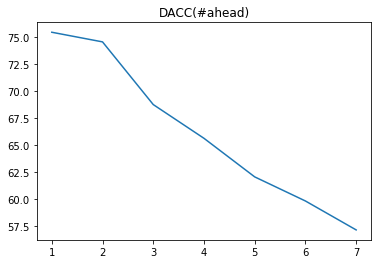

--- 21.326s to run segment

--- 35.864s to full run 300 - 638



        #################################
        # gbtc
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 140512236564560
Tensor("lstm_41_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_42 (Dropout)         (None, 7)                 0         
__________________________

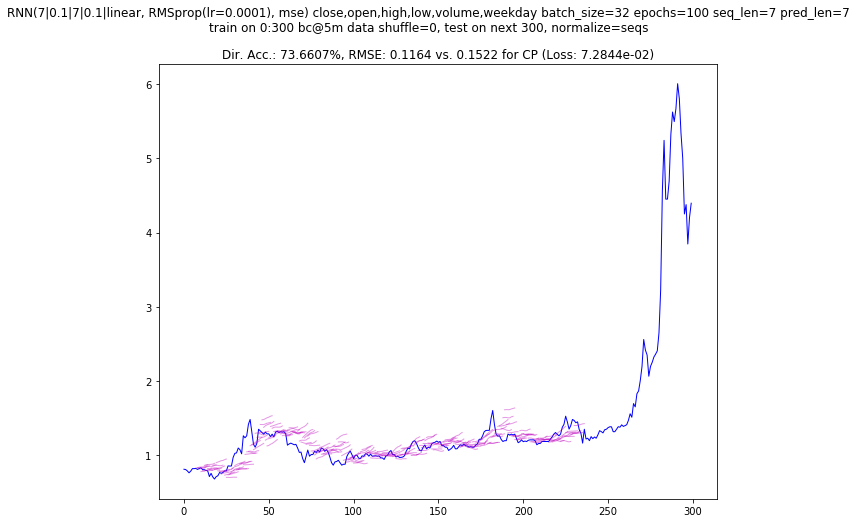

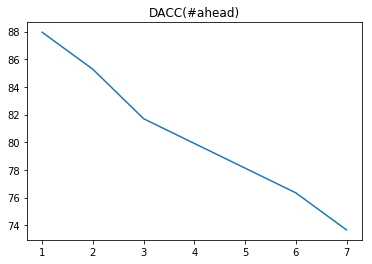

--- 15.921s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 140512207985104
Tensor("lstm_43_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_43 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_44 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 317us/step - loss: 0.0135 - val_loss: 0.2543
Epoch 68/100
262/262 [==============================] - 0s 309us/step - loss: 0.0130 - val_loss: 0.2537
Epoch 69/100
262/262 [==============================] - 0s 316us/step - loss: 0.0131 - val_loss: 0.2532
Epoch 70/100
262/262 [==============================] - 0s 296us/step - loss: 0.0136 - val_loss: 0.2525
Epoch 71/100
262/262 [==============================] - 0s 302us/step - loss: 0.0134 - val_loss: 0.2521
Epoch 72/100
262/262 [==============================] - 0s 328us/step - loss: 0.0127 - val_loss: 0.2514
Epoch 73/100
262/262 [==============================] - 0s 322us/step - loss: 0.0133 - val_loss: 0.2508
Epoch 74/100
262/262 [==============================] - 0s 362us/step - loss: 0.0133 - val_loss: 0.2502
Epoch 75/100
262/262 [==============================] - 0s 313us/step - loss: 0.0128 - val_loss: 0.2498
Epoch 76/100
262/262 [==============================] - 0s 327us/step - loss:

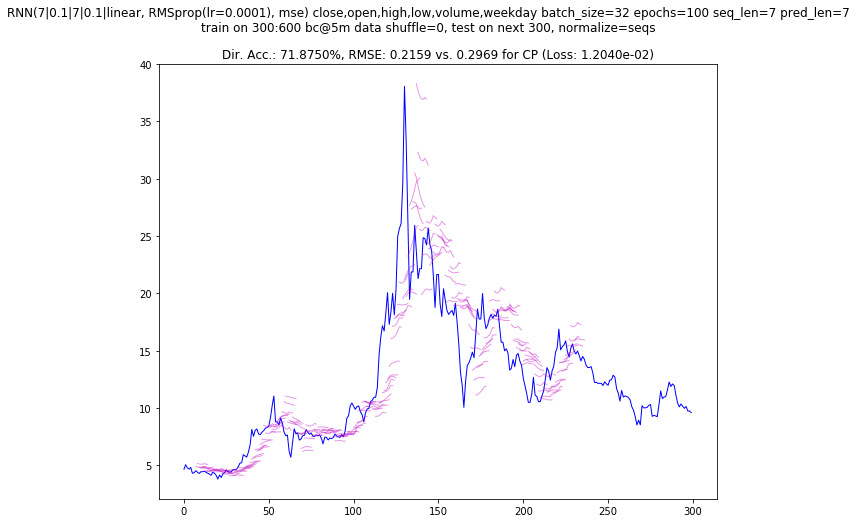

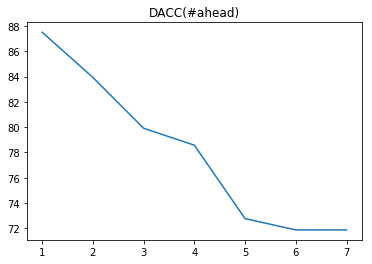

--- 15.701s to run segment

--- 31.623s to full run 300 - 638



        #################################
        # mara
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 140512185088464
Tensor("lstm_45_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_46 (Dropout)         (None, 7)                 0         
__________________________

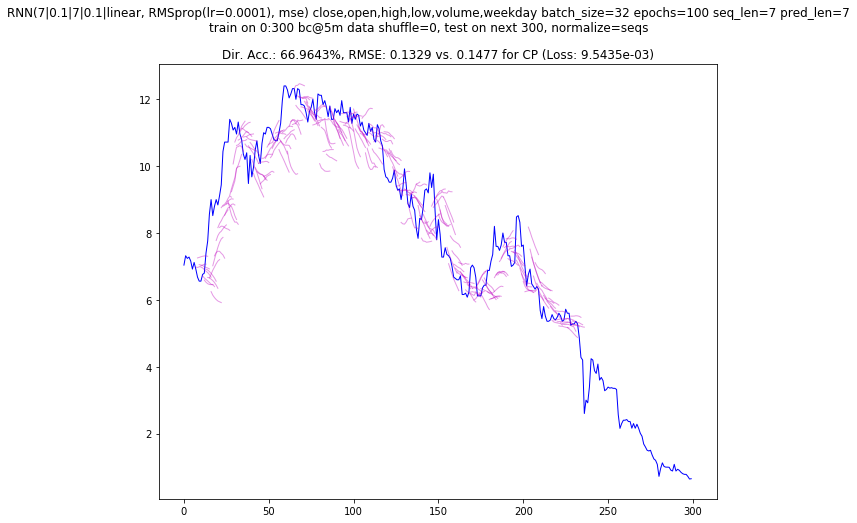

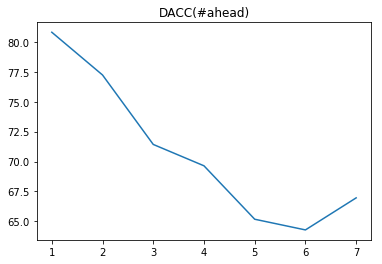

--- 16.481s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140512164795600
Tensor("lstm_47_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_47 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_48 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 323us/step - loss: 0.0184 - val_loss: 0.0504
Epoch 68/100
262/262 [==============================] - 0s 329us/step - loss: 0.0177 - val_loss: 0.0503
Epoch 69/100
262/262 [==============================] - 0s 302us/step - loss: 0.0185 - val_loss: 0.0503
Epoch 70/100
262/262 [==============================] - 0s 311us/step - loss: 0.0179 - val_loss: 0.0502
Epoch 71/100
262/262 [==============================] - 0s 317us/step - loss: 0.0184 - val_loss: 0.0502
Epoch 72/100
262/262 [==============================] - 0s 322us/step - loss: 0.0192 - val_loss: 0.0502
Epoch 73/100
262/262 [==============================] - 0s 307us/step - loss: 0.0181 - val_loss: 0.0502
Epoch 74/100
262/262 [==============================] - 0s 311us/step - loss: 0.0188 - val_loss: 0.0501
Epoch 75/100
262/262 [==============================] - 0s 293us/step - loss: 0.0192 - val_loss: 0.0501
Epoch 76/100
262/262 [==============================] - 0s 309us/step - loss:

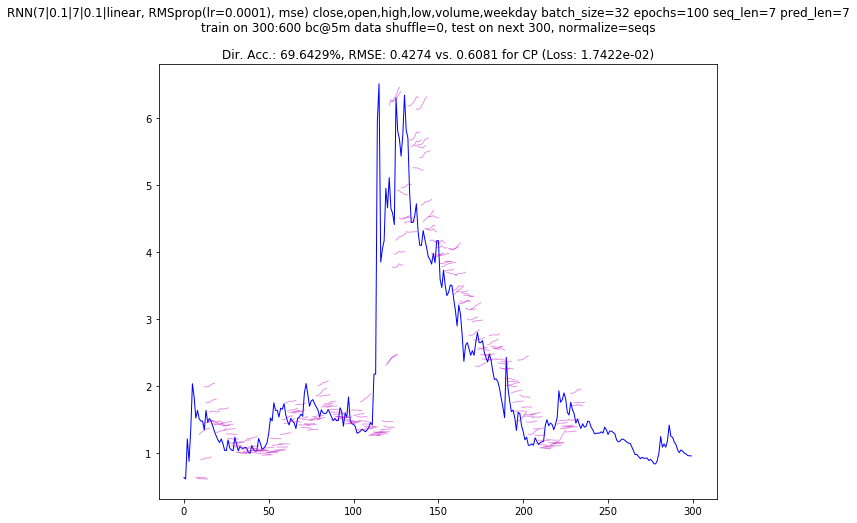

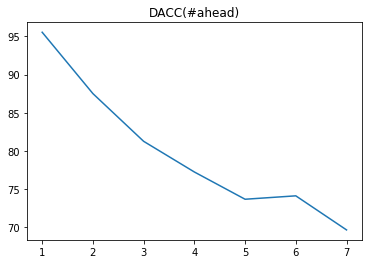

--- 17.639s to run segment

--- 34.121s to full run 300 - 638



In [16]:
OHLCW_PARAMS = DEFAULT_PARAMS.copy()
OHLCW_PARAMS['features'] = [
    'close', 'open', 'high', 'low', 'volume', 'weekday',
]

for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(300, len(data) - 300 - 7, data,
             out_filename='./full_results/stock_%s_ohlcw_btc.csv' % stock,
             write_csv_header=True,
             params=OHLCW_PARAMS)

In [17]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    filename = './full_results/stock_%s_ohlcw_btc.csv' % stock
    r = pd.read_csv(filename)
    dd(r)
    print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
    print("> RMSE: %.4f, vs. %.4f for CP" % (
        r['rmse'].str.replace('%', '').astype(float).mean(),
        r['rmse_cp'].str.replace('%', '').astype(float).mean(),
    ))



        #################################
        # ostk
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.005276  0.0666%  0.0723%  63.3929%  
1      300    False      seqs       0.004398  0.1664%  0.2325%  73.6607%

> DACC: 68.53%
> RMSE: 0.1165, vs. 0.1524 for CP


        #################################
        # riot
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.008205  0.1510%  0.1910%  67.4107%  
1      300    False      seqs       0.013761  0.3211%  0.4457%  72.3214%

> DACC: 69.87%
> RMSE: 0.2360, vs. 0.3184 for CP


        #################################
        # amd
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.008282  0.1231%  0.1548%  70.0893%  
1      300    False      seqs       0.008795  0.0939%  0.1082%  64.7321%

> DACC: 67.41%
> RMSE: 0.1085, vs. 0.1315 for CP


        #################################
        # otiv
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.018959  0.1132%  0.1535%  71.4286%  
1      300    False      seqs       0.013613  0.1576%  0.2366%  74.1071%

> DACC: 72.77%
> RMSE: 0.1354, vs. 0.1951 for CP


        #################################
        # nvda
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.004276  0.0796%  0.1064%  78.1250%  
1      300    False      seqs       0.006312  0.0620%  0.0872%  73.6607%

> DACC: 75.89%
> RMSE: 0.0708, vs. 0.0968 for CP


        #################################
        # sieb
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.007430  0.1230%  0.1688%  70.5357%  
1      300    False      seqs       0.014491  0.4061%  0.5809%  57.1429%

> DACC: 63.84%
> RMSE: 0.2646, vs. 0.3749 for CP


        #################################
        # gbtc
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.072844  0.1164%  0.1522%  73.6607%  
1      300    False      seqs       0.012040  0.2159%  0.2969%  71.8750%

> DACC: 72.77%
> RMSE: 0.1662, vs. 0.2245 for CP


        #################################
        # mara
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...         300       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.009543  0.1329%  0.1477%  66.9643%  
1      300    False      seqs       0.017422  0.4274%  0.6081%  69.6429%

> DACC: 68.30%
> RMSE: 0.2802, vs. 0.3779 for CP


## +BTC derived



        #################################
        # ostk
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.016s to model compilation time


--- Created model id: 140512259958160
Tensor("lstm_49_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_50 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_25 (Dense)       

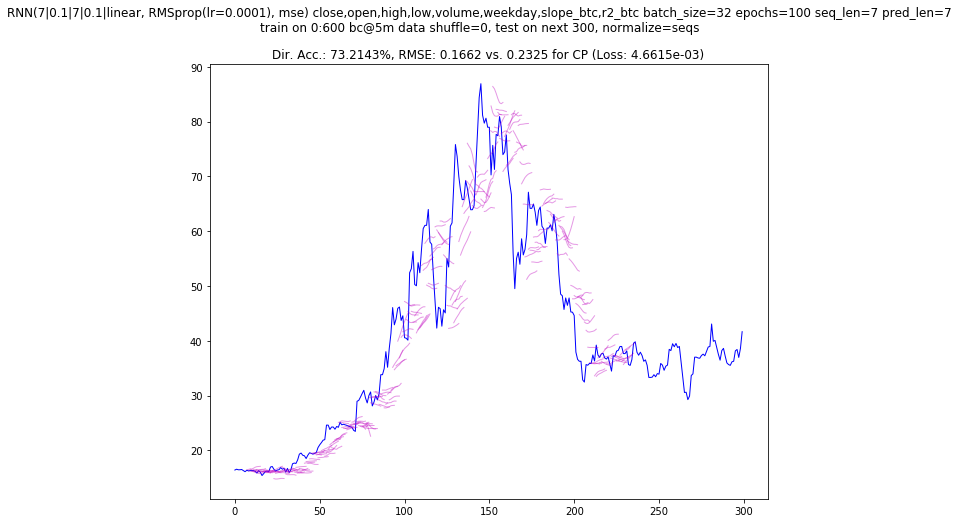

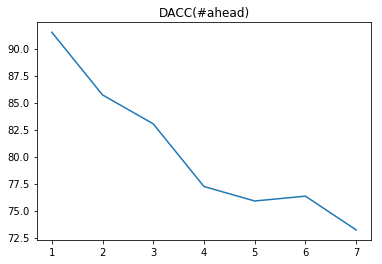

--- 20.790s to run segment

--- 20.791s to full run 600 - 638



        #################################
        # riot
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 140512208817040
Tensor("lstm_51_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_51 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_52 (Dropout)         (None, 7)                 0         
__________________________

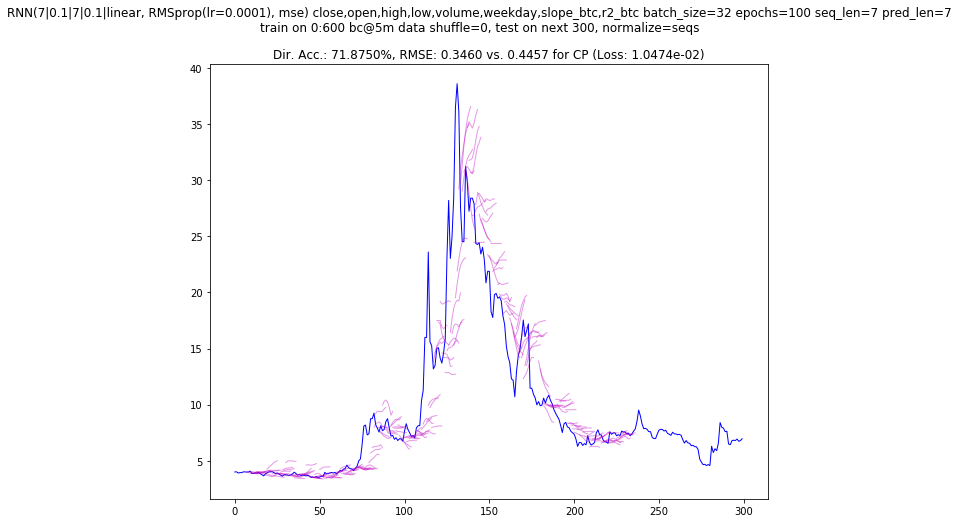

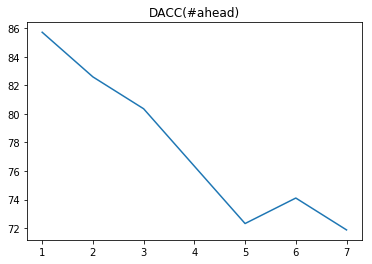

--- 22.984s to run segment

--- 22.984s to full run 600 - 638



        #################################
        # amd
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 140512113823184
Tensor("lstm_53_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_53 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_54 (Dropout)         (None, 7)                 0         
___________________________

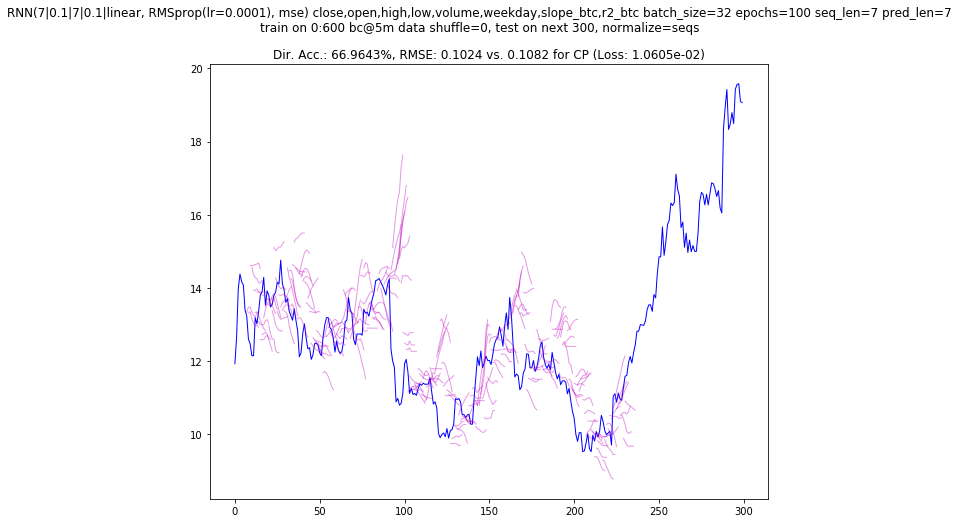

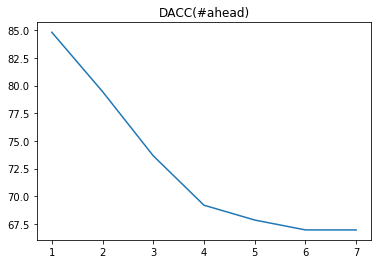

--- 26.428s to run segment

--- 26.428s to full run 600 - 638



        #################################
        # otiv
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.019s to model compilation time


--- Created model id: 140512091371728
Tensor("lstm_55_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_56 (Dropout)         (None, 7)                 0         
__________________________

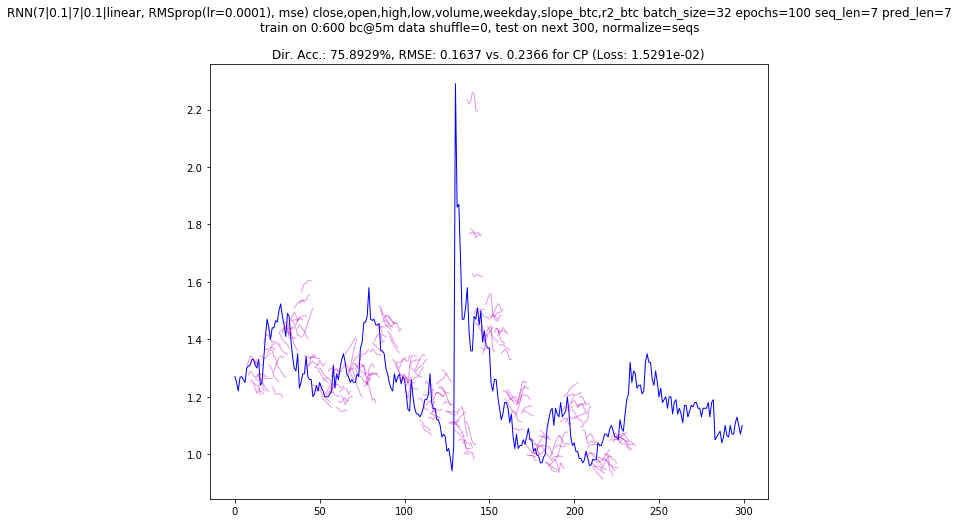

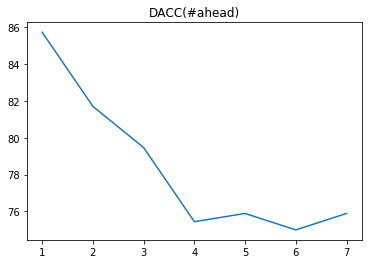

--- 24.737s to run segment

--- 24.737s to full run 600 - 638



        #################################
        # nvda
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.016s to model compilation time


--- Created model id: 140512068451728
Tensor("lstm_57_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 7)                 0         
__________________________

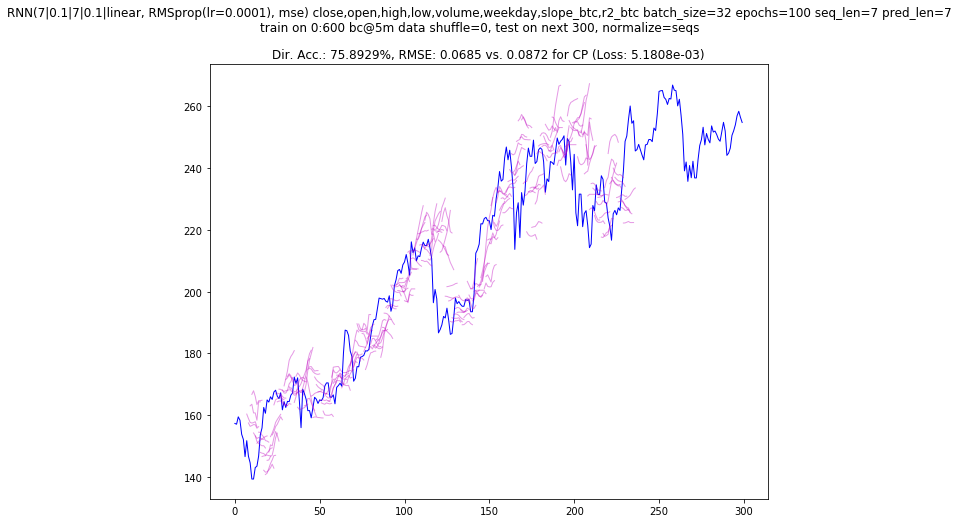

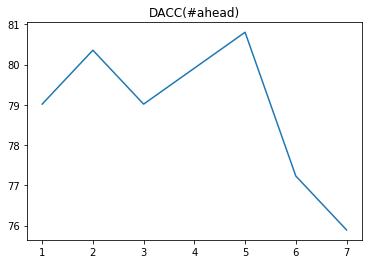

--- 25.384s to run segment

--- 25.384s to full run 600 - 638



        #################################
        # sieb
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 140512257619408
Tensor("lstm_59_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_59 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_60 (Dropout)         (None, 7)                 0         
__________________________

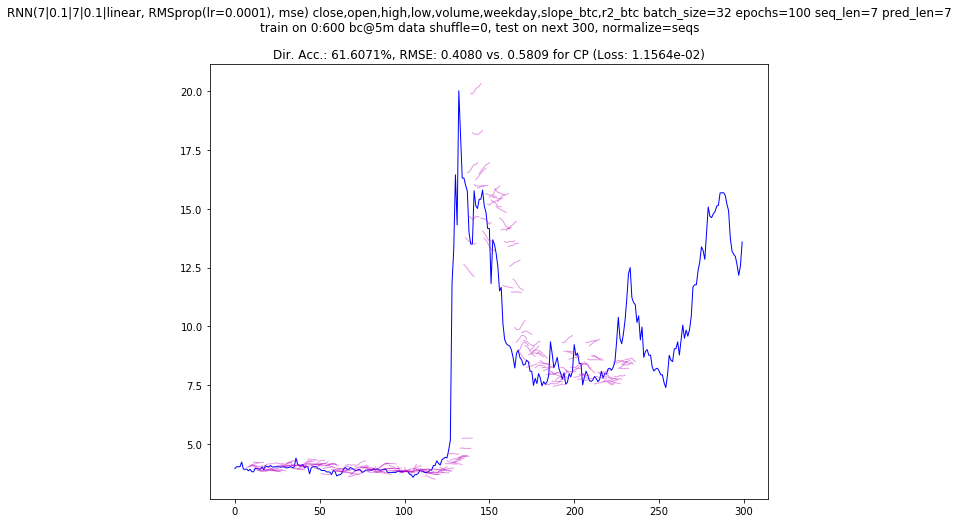

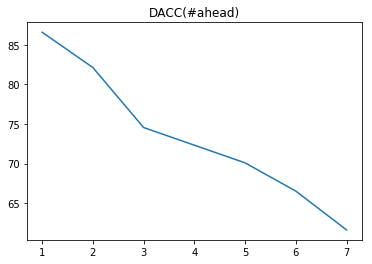

--- 26.661s to run segment

--- 26.661s to full run 600 - 638



        #################################
        # gbtc
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.024s to model compilation time


--- Created model id: 140512044326160
Tensor("lstm_61_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_61 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_62 (Dropout)         (None, 7)                 0         
__________________________

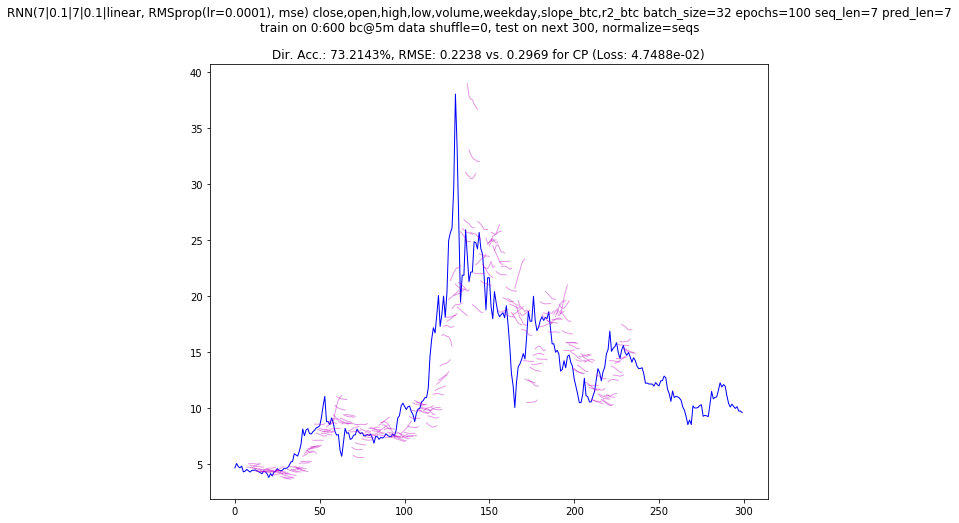

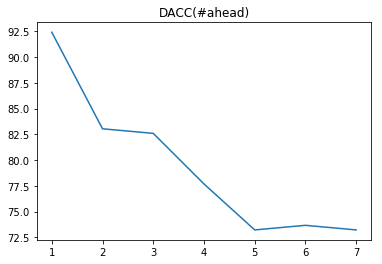

--- 27.716s to run segment

--- 27.716s to full run 600 - 638



        #################################
        # mara
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.019s to model compilation time


--- Created model id: 140512024518480
Tensor("lstm_63_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_63 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_64 (Dropout)         (None, 7)                 0         
__________________________

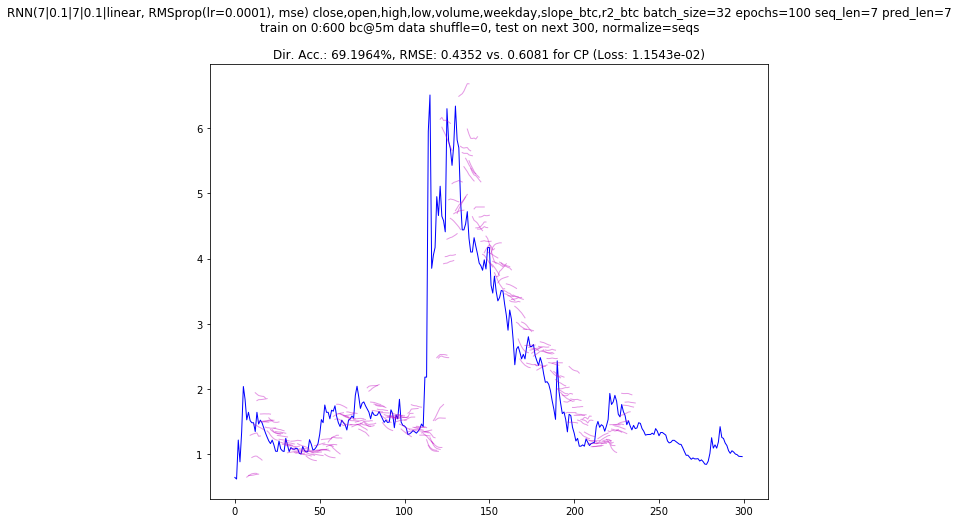

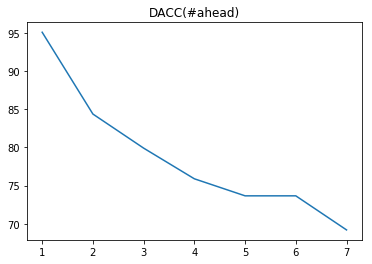

--- 28.949s to run segment

--- 28.949s to full run 600 - 638



In [18]:
OHLCW_BTC_PARAMS = DEFAULT_PARAMS.copy()
OHLCW_BTC_PARAMS['features'] = [
    'close', 'open', 'high', 'low', 'volume', 'weekday',
    'slope_btc', 'r2_btc',
]
OHLCW_BTC_PARAMS['train_sz'] = 600

for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(600, len(data) - 300 - 7, data,
             out_filename='./full_results/stock_%s_ohlcw_btc.btc.csv' % stock,
             write_csv_header=True,
             params=OHLCW_BTC_PARAMS)

In [19]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    filename = './full_results/stock_%s_ohlcw_btc.btc.csv' % stock
    r = pd.read_csv(filename)
    dd(r)
    print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
    print("> RMSE: %.4f, vs. %.4f for CP" % (
        r['rmse'].str.replace('%', '').astype(float).mean(),
        r['rmse_cp'].str.replace('%', '').astype(float).mean(),
    ))



        #################################
        # ostk
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.004661  0.1662%  0.2325%  73.2143%

> DACC: 73.21%
> RMSE: 0.1662, vs. 0.2325 for CP


        #################################
        # riot
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.010474  0.3460%  0.4457%  71.8750%

> DACC: 71.88%
> RMSE: 0.3460, vs. 0.4457 for CP


        #################################
        # amd
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.010605  0.1024%  0.1082%  66.9643%

> DACC: 66.96%
> RMSE: 0.1024, vs. 0.1082 for CP


        #################################
        # otiv
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.015291  0.1637%  0.2366%  75.8929%

> DACC: 75.89%
> RMSE: 0.1637, vs. 0.2366 for CP


        #################################
        # nvda
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.005181  0.0685%  0.0872%  75.8929%

> DACC: 75.89%
> RMSE: 0.0685, vs. 0.0872 for CP


        #################################
        # sieb
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.011564  0.4080%  0.5809%  61.6071%

> DACC: 61.61%
> RMSE: 0.4080, vs. 0.5809 for CP


        #################################
        # gbtc
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.047488  0.2238%  0.2969%  73.2143%

> DACC: 73.21%
> RMSE: 0.2238, vs. 0.2969 for CP


        #################################
        # mara
        #################################
        


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...           0       600   

   test_on  shuffle normalize  training_loss     rmse  rmse_cp   dir_acc  
0      300    False      seqs       0.011543  0.4352%  0.6081%  69.1964%

> DACC: 69.20%
> RMSE: 0.4352, vs. 0.6081 for CP


## LR model for comparison



        #################################
        # ostk
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (now at 280)...
> Predicting (now

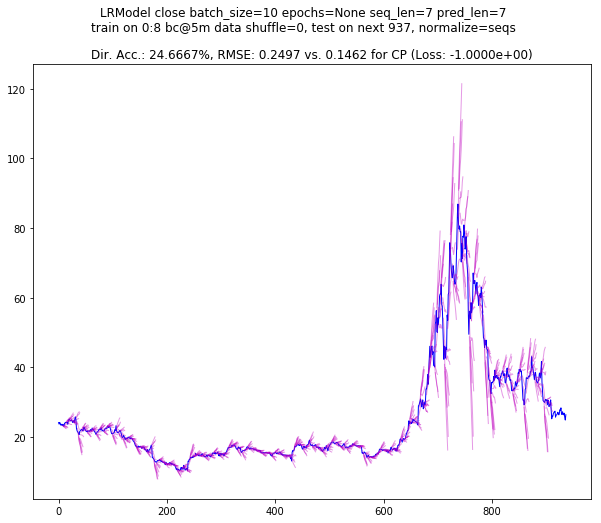

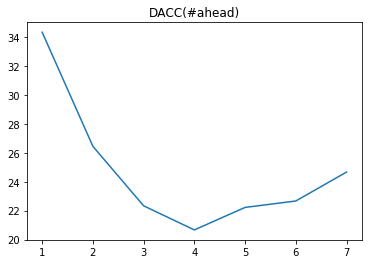

--- 3.187s to run experiment



        #################################
        # riot
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

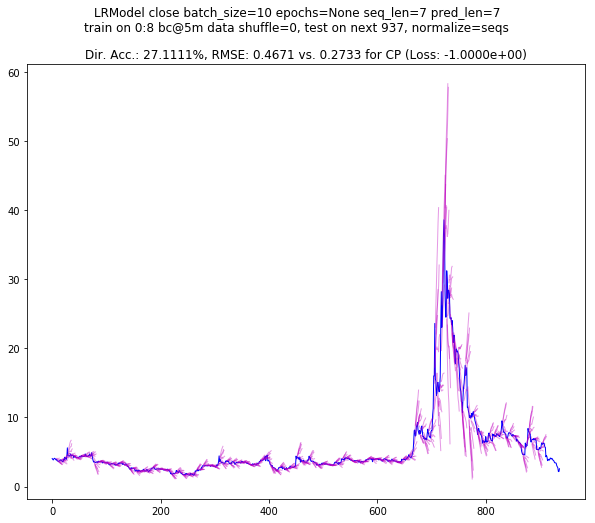

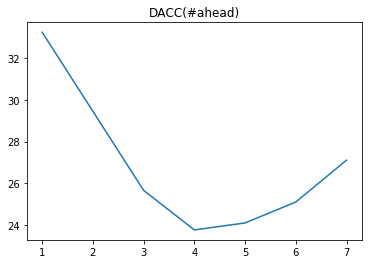

--- 2.885s to run experiment



        #################################
        # amd
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (now

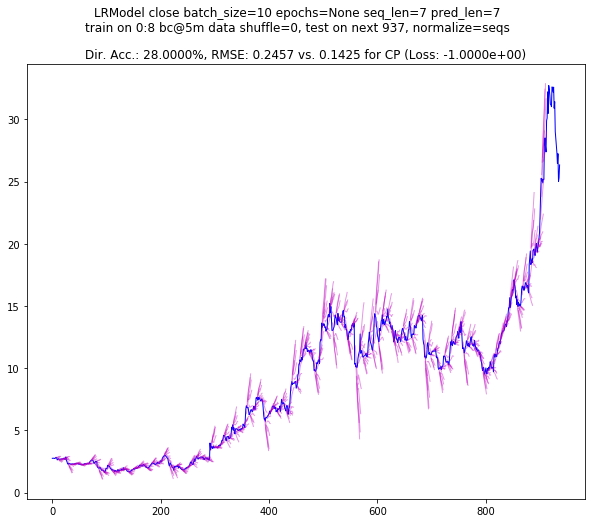

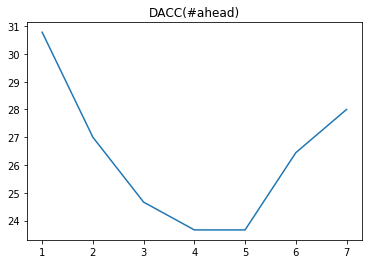

--- 2.909s to run experiment



        #################################
        # otiv
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

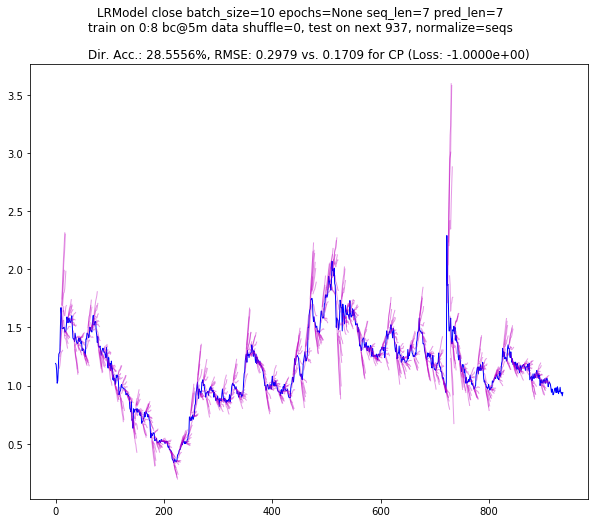

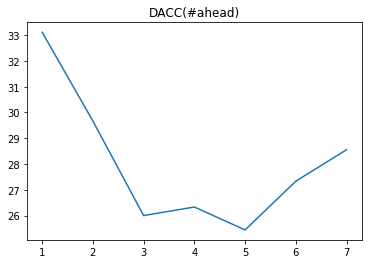

--- 2.899s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

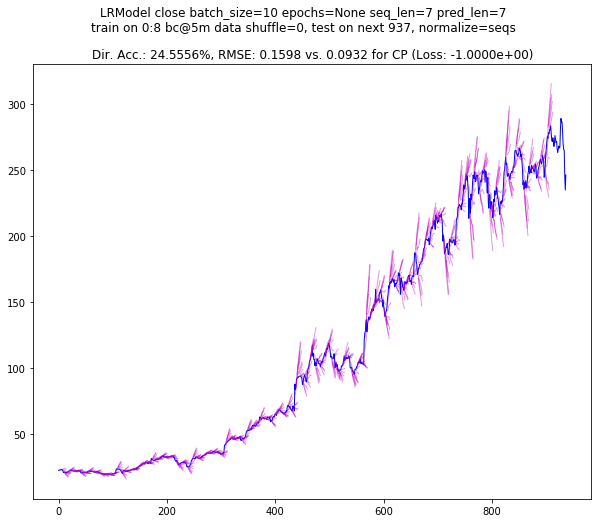

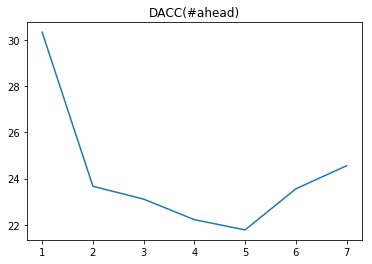

--- 2.988s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

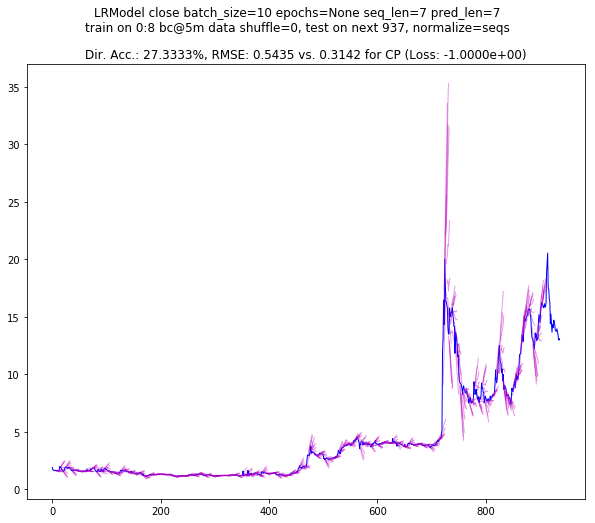

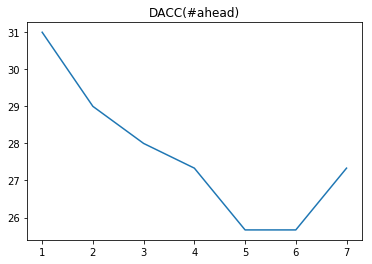

--- 3.031s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

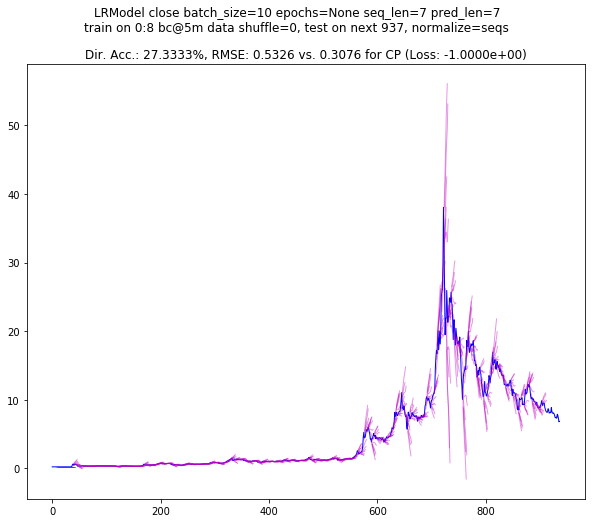

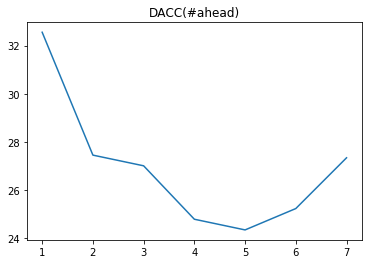

--- 3.138s to run experiment



        #################################
        # mara
        #################################
        
data ~ (945, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (no

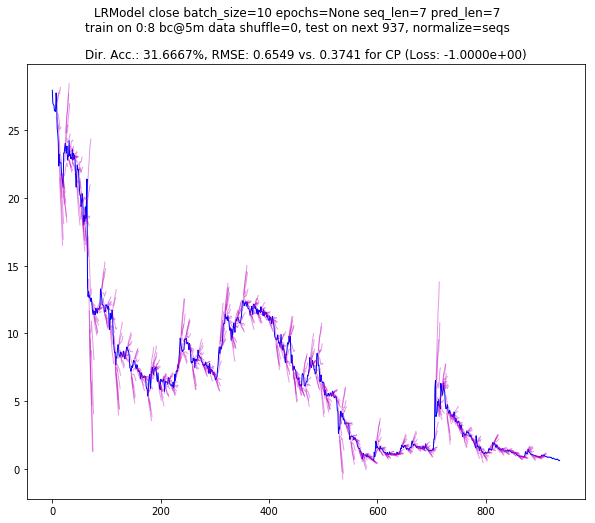

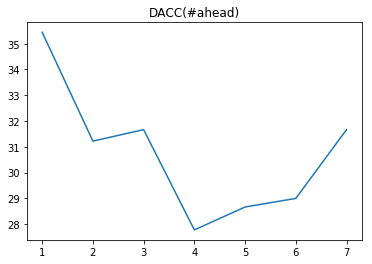

--- 4.380s to run experiment



In [28]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close'],
            from_i=0,
            train_sz=8,
            test_sz=len(data) - 8,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=LRModel,
            # training:
            epochs=None,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=False,
        )